In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults 
from sklearn.metrics import mean_squared_error
import pandas as pd
import warnings
import itertools
import statsmodels
import statsmodels.api as sm
import itertools


Using TensorFlow backend.
C:\Users\gleny\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\gleny\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\gleny\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\gleny\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [61]:
# define a function to convert a vector of time series into a 2D matrix
def convertSeriesToMatrix(vectorSeries, sequence_length):
    matrix = []
    for i in range(len(vectorSeries)-sequence_length+1):
        matrix.append(vectorSeries[i:i+sequence_length])
    return matrix

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 19, 100)           40800     
_________________________________________________________________
dropout_19 (Dropout)         (None, 19, 100)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_20 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
_________________________________________________________________
activation_10 (Activation)   (None, 1)                 0         
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_______________________________________________

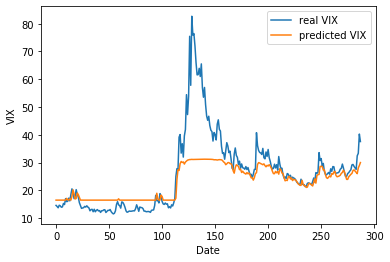

In [101]:
# random seed
np.random.seed(1111)

# load the data
path_to_dataset = 'convertcsv.csv'
sequence_length = 20

# vector to store the time series
vector_vix = []
with open(path_to_dataset) as f:
    next(f) # skip the header row
    for line in f:
        fields = line.split(',')
        vector_vix.append(float(fields[52]))

# convert the vector to a 2D matrix
matrix_vix = convertSeriesToMatrix(vector_vix, sequence_length)
matrix_vix = np.array(matrix_vix)




shifted_value = matrix_vix.mean()
matrix_vix -= shifted_value

# from sklearn.model_selection import train_test_split


# X_train,X_test,Y_train,Y_test = train_test_split(matrix_vix[:, :-1],
#                                                  matrix_vix[:, -1],
#                                                  test_size=0.2)

# print(X_train.shape)
# print(Y_train.shape)
# # the input to LSTM layer needs to have the shape of (number of samples, the dimension of each element)
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Y_train = np.reshape(Y_train, (Y_train.shape[0], 1))
# Y_test = np.reshape(Y_test, (Y_test.shape[0], 1))



train_row = int(round(0.85 * matrix_vix.shape[0]))
train_set = matrix_vix[:train_row, :]

# shuffle the training set (but do not shuffle the test set)
np.random.shuffle(train_set)
# the training set
X_train = train_set[:, :-1]
# the last column is the true value to compute the mean-squared-error loss
Y_train = train_set[:, -1]
# the test set
X_test = matrix_vix[train_row:, :-1]
Y_test = matrix_vix[train_row:, -1]

# the input to LSTM layer needs to have the shape of (number of samples, the dimension of each element)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


# build the model
model = Sequential()
# layer 1: LSTM
model.add(LSTM(units=100, input_shape=(19, 1), return_sequences=True))
model.add(Dropout(0.2))
# layer 2: LSTM
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
# layer 3: dense
# linear activation: a(x) = x
model.add(Dense(units=1))
model.add(Activation('linear'))
# compile the model
model.compile(loss="mse", optimizer="rmsprop")
print(model.summary())


# train the model
model.fit(X_train, Y_train, batch_size=512, epochs=50, validation_split=0.05, verbose=1)


# evaluate the result
test_mse = model.evaluate(X_test, Y_test, verbose=1)
print ('\nThe mean squared error (MSE) on the test data set is %.3f over %d test samples.' % (test_mse, len(Y_test)))

# get the predicted values
predicted_values = model.predict(X_test)
num_test_samples = len(predicted_values)
predicted_values = np.reshape(predicted_values, (num_test_samples,1))


diviation = Y_test - predicted_values

# plot the results (LSTM ONLY)
fig = plt.figure()
plt.plot(Y_test+ shifted_value, label='real VIX')
plt.plot(model.predict(X_test) + shifted_value, label='predicted VIX')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.legend()
plt.show()
fig.savefig('output_prediction.jpg', bbox_inches='tight')

# save the result into txt file
#test_result = list(zip(predicted_values, Y_test)) + shifted_value
#np.savetxt('output_result.txt', test_result)



In [94]:
x_all = matrix_vix[:, :-1]
y_all = matrix_vix[:,-1]

x_all = np.reshape(x_all, (x_all.shape[0], x_all.shape[1], 1))
pred_all = model.predict(x_all)
pred_all = pred_all.flatten()

print(pred_all+shifted_value)

[24.948187 14.214883 11.085015 ... 29.439228 30.407297 31.485231]


In [95]:
divi_for_training = y_all - pred_all


real = y_all + shifted_value
predic = pred_all + shifted_value


# fig = plt.figure()
# # plt.plot(y_all + shifted_value, label='real VIX')
# # plt.plot(pred_all + shifted_value, label='predicted VIX')
# plt.plot(fir[1000:1350], label='real VIX')
# plt.plot(sec[1000:1350], label='predicted VIX')
# plt.xlabel('Date')
# plt.ylabel('VIX')
# plt.legend()
# plt.show()
# fig.savefig('output_prediction.jpg', bbox_inches='tight')

# print(divi_for_training.shape)

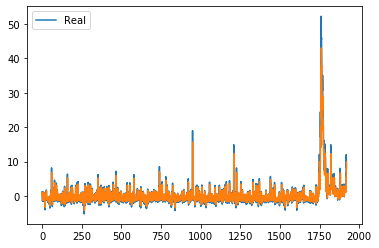

In [96]:
arima_model = ARIMA(residual, order=(1,0,0)) 
ax = plt.gca()
results = arima_model.fit() 
plt.plot(residual)
#plt.plot(results.fittedvalues, color='red')
ax.legend(['Real', 'Forecast'])

forecast = results.predict()
#rmse = mean_squared_error(residual, forecast)**0.5
plt.plot(forecast)
plt.show()

In [97]:
# dynamic arima trainig

def evaluate_arima_model(residual):
    # prepare training dataset
    train_size = int(len(residual) * 0.85)
    train = residual[0:train_size]
    test = residual[train_size:]
    
    history = [x for x in train]
    # make predictions
    predictions = list()
    
    for t in range(len(test)):
        
        model = ARIMA(history, order=(1,0,0))
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        
    plt.plot(predictions, color='orange')
    plt.plot(history[train_size:], color='blue')
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    print(error)
    return predictions

23.52073148531189


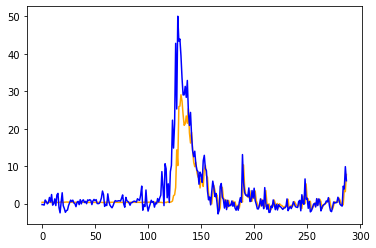

In [98]:
arima_residual = evaluate_arima_model(divi_for_training)

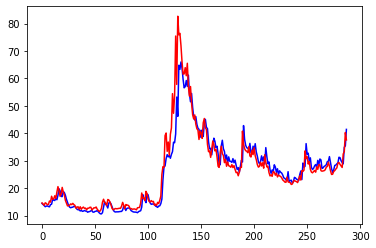

In [99]:
# plot of test set (LSTM+ARIMA)
plt.plot(predicted_values+shifted_value+bbbb, color='blue')
plt.plot(Y_test+shifted_value, color='red')

In [100]:
mean_squared_error((Y_test+shifted_value)[-100:], (predicted_values+shifted_value+bbbb)[-100:])

7.409452349469858